In [38]:
import pandas as pd
import numpy as np
import json
import pickle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
ds = []
with open('drive/MyDrive/colab/renttherunway_final_data.json') as f:
    for line in f:
        ds.append(json.loads(line))

In [41]:
df = pd.DataFrame(ds).replace("Unknown", np.nan)

In [42]:
df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016"


In [43]:
print("Number of unique users: {user:,}".format(user=df["user_id"].nunique()))
print("Number of unique items: {item:,}".format(item=df["item_id"].nunique()))

Number of unique users: 105,571
Number of unique items: 5,850


In [44]:
df.dropna(subset = ["rating"], inplace=True)

In [45]:
df["rating"] = df["rating"].apply(pd.to_numeric, errors="coerce") / 2

In [46]:
# Change rating to binary
rating_sucessful = (df["rating"] == 5.0) | (df["rating"] == 4.0) & (df["fit"] == "fit")
df["class_rating"] = np.where(rating_sucessful == True, 1, 0)

In [47]:
# Filter items with more than 3 rents

item_rating_count = pd.DataFrame(df.groupby("item_id")["rating"].count())
item_rating_count = item_rating_count.loc[(item_rating_count["rating"] > 3)]
item_rating_count = item_rating_count.reset_index()
df_filter = df[df["item_id"].isin(item_rating_count["item_id"])]

# Filter users with more than 4 rents

user_rating_count = pd.DataFrame(df_filter.groupby("user_id")["rating"].count())
user_rating_count = user_rating_count.loc[(user_rating_count.rating > 4)]
user_rating_count = user_rating_count.reset_index()
user_rating_count.drop("rating", axis=1, inplace=True)

df_filter = df_filter[df_filter["user_id"].isin(user_rating_count["user_id"])]
df_filter.reset_index(inplace=True, drop=True)

In [48]:
print('No. rents', len(df_filter))

No. rents 49909


In [49]:
train, test = train_test_split(df_filter, stratify=df_filter["user_id"], test_size=.15, random_state=43)
print('Train', len(train))
print('Test', len(test))

Train 42422
Test 7487


In [53]:
train.groupby(['item_id']).agg(['count']).sort_values(('fit', 'count'), ascending=False)

,fit,user_id,bust size,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,class_rating
,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count
item_id,,,,,,,,,,,,,,,
126335,138,138,129,113,138,138,138,137,138,138,138,138,137,138,138
174086,119,119,107,88,119,119,119,118,119,119,119,119,119,119,119
136110,105,105,93,82,105,105,105,101,105,105,105,105,105,105,105
172027,92,92,90,86,92,92,92,92,92,92,92,92,92,92,92
124553,85,85,74,74,85,85,85,80,85,85,85,85,85,85,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679098,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1462873,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [16]:
# Rating matrix
rating_matrix = train.pivot_table(values="rating", 
                                  columns="item_id", 
                                  index="user_id", 
                                  aggfunc="count", 
                                  fill_value=0)

In [17]:
rating_matrix.head()

item_id,1000254,1000270,1000739,1001122,1001785,1001829,1001857,1002298,1002863,1003076,1004015,1004940,1005880,1006362,1006590,1006741,1007290,1007691,1008472,1008474,1008562,1009245,1009409,1009546,1009845,1010328,1010926,1011749,1011971,1012189,1012832,1013498,1014293,1014880,1015626,1015917,1016759,1017726,1017773,1018136,...,975243,975506,976264,976594,977381,978935,979016,979046,980230,981993,982621,982932,983905,984289,985087,985499,986296,986324,986546,987052,987536,987569,987743,988239,989029,989581,990892,992169,992520,992623,993317,993753,993779,994031,994626,996851,997751,998947,999526,999837
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100157,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100215,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100536,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100540,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100751,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
# Similarity matrix
similarity_matrix = cosine_similarity(rating_matrix)

In [ ]:
def kmeans_k_clusters(k, sim_matrix):
    kmeans = KMeans(n_clusters = k, max_iter = 500, n_init = 30, random_state = 43).fit(sim_matrix)
    dist = {"k": k,
            "dist": kmeans.inertia_}
    return dist

In [ ]:
# Choose optimal k
# k_range = list(range(3, 20))
# dist = pd.DataFrame([kmeans_k_clusters(k, similarity_matrix) for k in tqdm(k_range)])

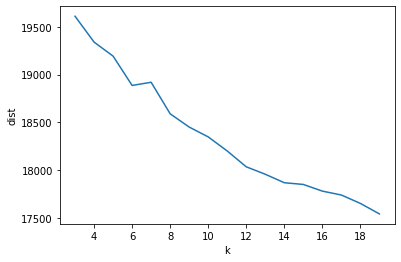

In [ ]:
sns.lineplot(data=dist, x="k", y="dist")

In [ ]:
rating_kmeans = KMeans(n_clusters = 14, max_iter = 500,  n_init = 30, random_state = 43).fit(similarity_matrix)
user_clusters = pd.DataFrame(rating_kmeans.labels_, columns=["cluster_n"])

In [20]:
rating_matrix["cluster"] = list(rating_kmeans.labels_)

In [22]:
cluster_item_rating = rating_matrix.melt(id_vars="cluster", value_name="rating")
cluster_item_rating = pd.DataFrame(cluster_item_rating.groupby(["cluster", "item_id"])["rating"].mean())
cluster_item_rating.reset_index(inplace=True)
cluster_item_rating.sort_values(["cluster", "rating"], ascending=False, inplace=True)

cluster_item_rating.head()

,cluster,item_id,rating
62761,13,1522253,1.791667
62204,13,123793,0.083333
62327,13,1298692,0.083333
62581,13,143094,0.083333
63151,13,172027,0.083333


In [24]:
def recommend(id):
    rating_matrix_copy = rating_matrix.copy()
    rating_matrix_copy.reset_index(inplace=True)
    user_and_cluster = rating_matrix_copy[rating_matrix_copy.user_id == id]
    return cluster_item_rating[cluster_item_rating.cluster.isin(user_and_cluster.cluster)][:100]

In [ ]:
test_user('180531')

In [ ]:
test[test.user_id == '180531']

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,class_rating
1052,small,180531,32d,588814,125lbs,5.0,wedding,This dress is perfect for a wedding or other f...,athletic,My favorite dress!,gown,"5' 4""",14,30,"November 25, 2015",1
40609,fit,180531,32d,352365,125lbs,5.0,everyday,I wore this with some chunky sandals for day i...,athletic,"Form fitting, fun, so many compliments",dress,"5' 4""",8,30,"October 27, 2017",1
42925,fit,180531,32d,1327789,125lbs,5.0,other,I loved this dress. I wore it to Easter servic...,athletic,Church with the in-laws,dress,"5' 4""",8,30,"July 5, 2017",1


In [ ]:
def test_user(user_id):
  ground_truth = test[test.user_id == user_id]
  top_60_acc = ground_truth[ground_truth.item_id.isin(recommend(user_id).item_id)]
  # print('Accuracy', len(top_60_acc[top_60_acc.class_rating == 1]))
  return len(top_60_acc[top_60_acc.class_rating == 1])

In [33]:
recommendations = {}
for user_id in test.user_id.unique():
  recommendations[user_id] = {row['item_id']: row['rating'] for i, row in recommend(user_id).iterrows()}

In [37]:
with open('recommendations_collaborative_filtering.json', 'w') as f:
  json.dump(recommendations, f)